# Steinschlagrisiko cwm1

## 1. Einleitung
## 1.1 Aufgabenstellung
Die Kantonsstrasse unterhalb Schiers (GR) ist vom Steinschlag betroffen. Steine lösen sich von zwei unterschiedlichen Stellen an der Felswand ab (Ablösungszone 1 und Ablösungszone 2). Der betroffene Strassenabschnitt ist mit Steinfangnetzen gesichert, die jedoch in die Jahre gekommen sind und die angestrebte Sicherheit nicht mehr gewährleisten können. Die Planung für Ersatznetze hat bereits begonnen, kann aber frühstens in einem Jahr umgesetzt werden.

In den letzten Monaten haben sich mehrere Steinschlagereignisse ereignet. Kommt es im Lauf des nächsten Jahres zu weiteren vergleichbaren Ereignissen, könnten die alten Sicherheitsnetze versagen und die Verkehrsteilnehmer einem grossen Sicherheitsrisiko ausgesetzt sein. Die Bevölkerung ist verunsichert und der Kantonsingenieur muss schnell entscheiden, ob das Risiko für die Verkehrsteilnehmer zu gross ist und die Kantonsstrasse vorübergehend gesperrt werden muss. Der Kantonsingenieur hat sie beauftragt, anhand von vorhanden Daten die Wahrscheinlichkeit eines Todesfalls zu berechnen und eine Empfehlung bezüglich der Schliessung bzw Offenhaltung der Strasse auszusprechen.

Damit die Strasse offen bleiben kann, muss gezeigt werden, dass die jährliche Wahrscheinlichkeit von Todesfällen infolge Steinschlags kleiner als 10-4  ist. Für die Berechnungen soll ein gut strukturierter und dokumentierter Code in Python oder R entwickelt werden.


### 1.2 Grundlagen
Für die Planung der neuen Sicherheitsnetze, hat ein beauftragter Geologe, über drei Monate Daten zu den Steinschlagereignisse aufgenommen. Dabei wurde Steingeschwindigkeit, Steinmasse und Zeitpunkt und der Zeitpunkt des Ereignis registriert. Diese Daten können von Ihnen zur Modellbildung verwendet werden und stehen unter folgenden Links zur Verfügung:

Ereignis aus Ablösungszone 1: https://www.dropbox.com/s/i58gdv6pzi03rhr/out_1.csv?dl=0

Ereignis aus Ablösungszone 2: https://www.dropbox.com/s/3nk9pv7nzz8f0qb/out_2.csv?dl=0

NB: Die Geschwindigkeit ist durch einen Radar aufgenommen und sehr präzise. Die Masse ist eine Experten-Schätzung des Geologen.
Ein beauftragtes Ingenieurbüro hat geschätzt, dass die Sicherheitsnetze bis zu einer Aufprallenergie von 1000 kJ sicher sind. Falls bereits ein Stein mit über 2000kg in den Sicherheitsnetzen liegt, beträgt die Aufprallenergie, die von den Sicherheitsnetzen aufgenommen werden kann, nur noch 500 kJ. Steine in den Sicherheitsnetze werden vom Unterhaltsteam entfernt (die Reaktionszeit beträgt 24 Stunden).
Das tägliche Verkehrsaufkommen beträgt 1200 Autos. Stau kommt auf der Strecke nicht vor. Die Tempolimite beträgt 60 km/h. 

## 2. Bibliotheken importieren

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from fitter import Fitter, get_common_distributions, get_distributions

## 3. Vorbereitung der Daten
### 3.1 Daten einlesen und reinigen

In [5]:
# Daten laden
df1 = pd.read_csv("out_1.csv")
df2 = pd.read_csv("out_2.csv")

# Spaltennamen von df2 ändern, so dass sie die Spaltennamen von df1 entsprechen
df2 = df2.rename(columns={"Date":"Datum","m [kg]":"Masse [kg]","v [m/s]":"Geschwindigkeit [m/s]"})

# Datentabelle auswählen
df1 = df1.loc[:, ["Datum","Uhrzeit","Masse [kg]","Geschwindigkeit [m/s]"]]
df2 = df2.loc[:, ["Datum","Uhrzeit","Masse [kg]","Geschwindigkeit [m/s]"]]

# Spalte Ablösungszone hinzufügen (Wird später bei der Visualisierung der Zonen verwendet)
df1['Ablösungszone'] = 1
df2['Ablösungszone'] = 2

# Zeilen mit NA Werte löschen
df1 = df1.dropna()
df2 = df2.dropna()

Datum und Uhrzeit in einer Spalte zusammenfügen damit daraus ein Datetime Objekt erstellt werden kann. Dieses Objekt wird dann verwendet, um die Zeitabstände der Steinschläge zu berechnen.

In [6]:
df1["Datum"] = pd.to_datetime(df1["Datum"] + " " + df1["Uhrzeit"])
df2["Datum"] = pd.to_datetime(df2["Datum"] + " " + df2["Uhrzeit"])

# Zeile 'Uhrzeit' löschen da diese nicht mehr gebraucht wird.
df1 = df1.drop("Uhrzeit", axis=1)
df2 = df2.drop("Uhrzeit", axis=1)

Zur Überprüfung zeigen wir die Dataframes der beiden Ablösungszonen an.

In [7]:
df1

,Datum,Masse [kg],Geschwindigkeit [m/s],Ablösungszone
0,2019-01-01 09:00:00,194.0,8.4,1
1,2019-01-01 21:00:00,224.0,8.8,1
2,2019-01-02 14:00:00,3104.0,9.2,1
3,2019-01-04 15:00:00,228.0,8.0,1
4,2019-01-05 23:00:00,755.0,7.0,1
...,...,...,...,...
63,2019-03-18 16:00:00,167.0,8.9,1
64,2019-03-22 18:00:00,2847.0,7.0,1
65,2019-03-26 00:00:00,44.0,8.9,1
66,2019-03-26 06:00:00,45.0,8.4,1


In [6]:
df2

,Datum,Masse [kg],Geschwindigkeit [m/s],Ablösungszone
0,2019-01-01 09:00:00,38.0,45.4,2
1,2019-01-03 06:00:00,187.0,41.6,2
2,2019-01-04 10:00:00,36.0,44.6,2
3,2019-01-07 14:00:00,6.0,41.2,2
4,2019-01-11 06:00:00,65.0,39.6,2
5,2019-01-11 16:00:00,58.0,33.2,2
6,2019-01-14 11:00:00,365.0,40.2,2
7,2019-01-16 02:00:00,22.0,46.5,2
8,2019-01-18 06:00:00,146.0,36.2,2
9,2019-01-19 17:00:00,29.0,38.3,2


In [9]:
df2[['Masse [kg]', 'Geschwindigkeit [m/s]']].describe()

,Masse [kg],Geschwindigkeit [m/s]
count,32.000000,32.000000
mean,99.250000,37.790625
std,104.072555,5.395778
min,0.000000,24.900000
25%,36.750000,33.200000
50%,58.000000,38.750000
75%,140.000000,41.725000
max,406.000000,46.500000


### 3.2 0-Wert ersetzen
Wir stellten fest, dass bei der Zone 2 eine Masse von 0kg vom Geologen geschätzt wurde. Rein physikalisch ist es nicht möglich, dass ein Stein die Masse von 0 kg annimmt. Wir nehmen also an, dass der Stein bei der Messung vergessen ging. 

Somit ist der Wert als Ausreisser zu betrachten und wurde durch den Median der Masse von der Ablösungszone 2 ersetzt, da diese robuster gegenüber Aus-reisser ist als der Durschnitt.

In [8]:
# Median berechnen
med = np.median(df2["Masse [kg]"])

# 0-Wert mit Median ersetzen
for i in range(len(df2["Masse [kg]"])):
    if df2["Masse [kg]"][i] <= 0:
        df2["Masse [kg]"][i] = med
        
# Prüfung, dass der neue Wert übernommen wurde
df2["Masse [kg]"][23]

58.0

## 4. Explorative Datenanalyse
In diesem Abschnitt visualisieren und analysieren wir die Daten anhand Histogramme und Streudiagramme. 
Somit können wir mögliche Abhängigkeiten der verschiedenen Daten feststellen.
Danach werden beide Zonen miteinander verglichen.

### 4.1 Histogramme

In [22]:
# Generiert ein Histogramm anhand der übergebenen Daten
def gen_hist(data, label, h_titel):
    plt.figure(figsize=(8, 8), dpi= 70, facecolor="w", edgecolor="k")
    plt.hist(data, density=False)
    plt.ylabel("Anzahl")
    plt.xticks(rotation=90)
    plt.xlabel(label)
    plt.title(h_titel, fontsize=15);   

#### 4.1.1 Ablösungszone 1

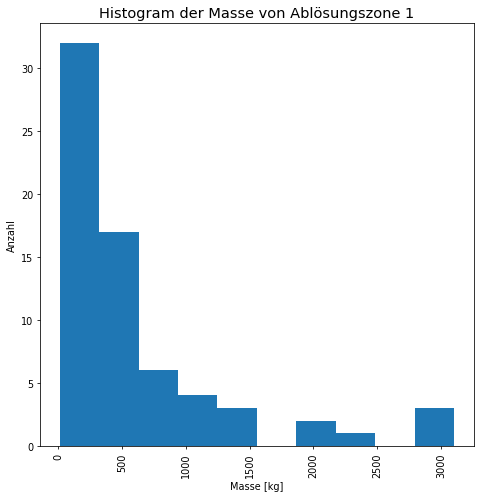

In [23]:
gen_hist(df1["Masse [kg]"], "Masse [kg]", "Histogram der Masse von Ablösungszone 1")

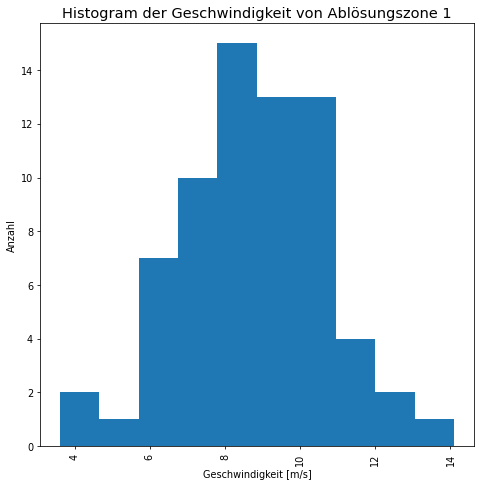

In [24]:
gen_hist(df1["Geschwindigkeit [m/s]"], "Geschwindigkeit [m/s]", "Histogram der Geschwindigkeit von Ablösungszone 1")

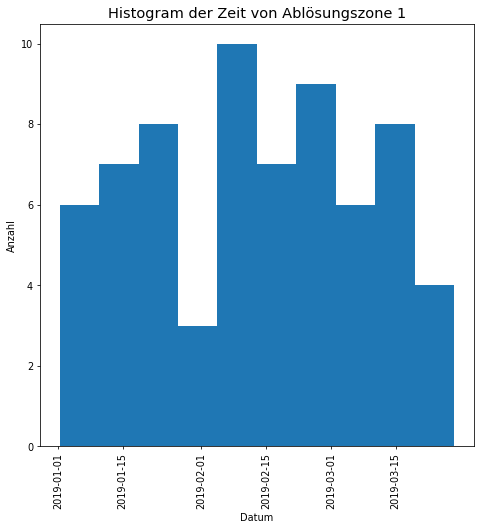

In [25]:
gen_hist(df1["Datum"], "Datum", "Histogram der Zeit von Ablösungszone 1")

#### 4.1.2 Ablösungszone 2

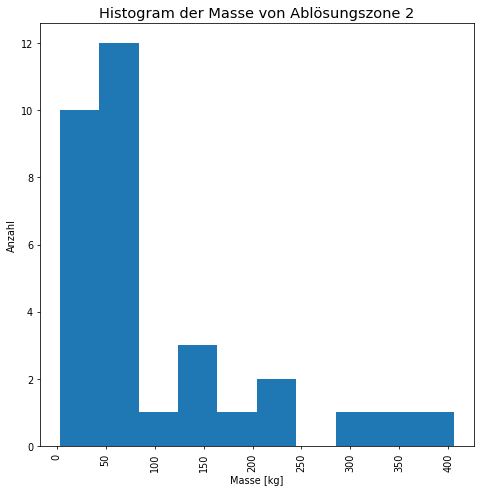

In [26]:
gen_hist(df2["Masse [kg]"], "Masse [kg]", "Histogram der Masse von Ablösungszone 2")

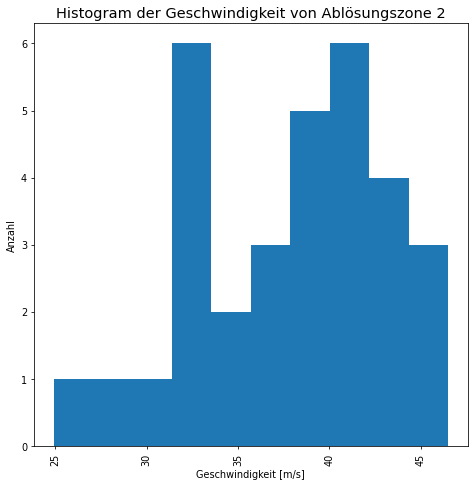

In [27]:
gen_hist(df2["Geschwindigkeit [m/s]"], "Geschwindigkeit [m/s]", "Histogram der Geschwindigkeit von Ablösungszone 2")

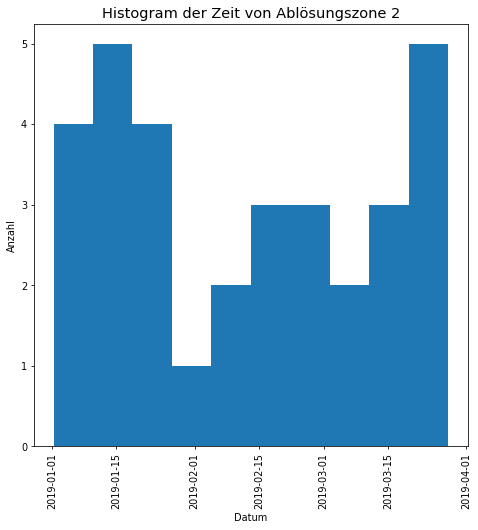

In [28]:
gen_hist(df2["Datum"], "Datum", "Histogram der Zeit von Ablösungszone 2")

### 4.2 Streudiagramme

#### 4.2.1 Ablösungszone 1

In [29]:
# Generiert ein Streudiagramm anhand der übergebenen Daten
def gen_streu(data_x, data_y, label_x, label_y, lim_x, lim_y, zone):
    plt.figure(figsize=(8, 8), dpi= 70, facecolor="w", edgecolor="k")
    plt.scatter(data_x, data_y)
    plt.gca().set(xlim=(0.0, lim_x), ylim=(0, lim_y), xlabel=label_x, ylabel=label_y)
    plt.title("Streudiagramm von {} & {}".format(label_x, label_y), fontsize=15)
    plt.show()

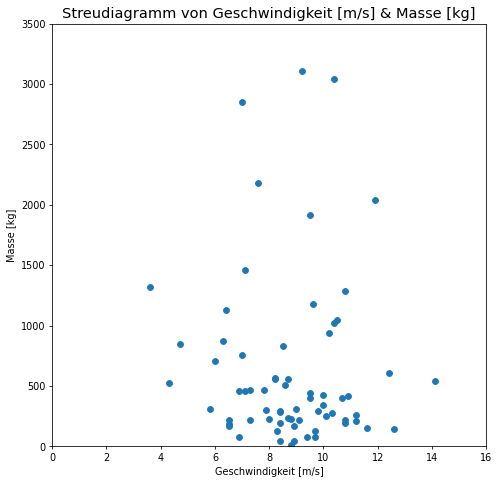

In [30]:
gen_streu(df1["Geschwindigkeit [m/s]"], df1["Masse [kg]"], "Geschwindigkeit [m/s]", "Masse [kg]", 16, 3500, "Ablösungszone 1")

Ablösungszone 1

#### 4.2.2 Ablösungszone 2

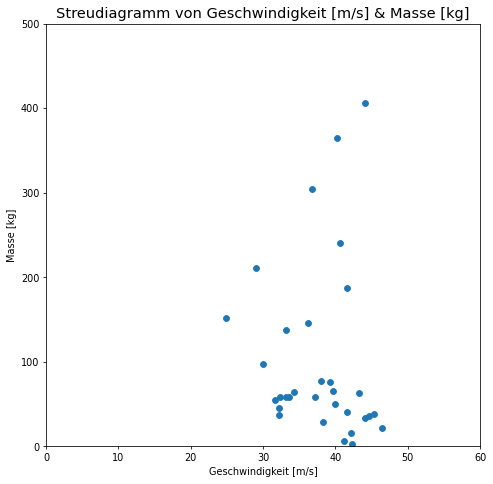

In [31]:
gen_streu(df2["Geschwindigkeit [m/s]"], df2["Masse [kg]"], "Geschwindigkeit [m/s]", "Masse [kg]", 60, 500, "Ablösungszone 2")

### 4.3 Vergleich Ablösungszone 1 und 2
Für den Vergleich der beiden Zonen haben wir die Datensätze von beiden Ablösungszonen zusammengefügt und daraus Boxplots und Streudiagramme erstellt.

In [32]:
# df1 und df2 zusammenfügen
df3 = pd.concat([df1, df2], ignore_index=True)
df3

,Datum,Masse [kg],Geschwindigkeit [m/s],Ablösungszone
0,2019-01-01 09:00:00,194.0,8.4,1
1,2019-01-01 21:00:00,224.0,8.8,1
2,2019-01-02 14:00:00,3104.0,9.2,1
3,2019-01-04 15:00:00,228.0,8.0,1
4,2019-01-05 23:00:00,755.0,7.0,1
...,...,...,...,...
95,2019-03-20 10:00:00,16.0,42.1,2
96,2019-03-21 13:00:00,211.0,29.0,2
97,2019-03-24 16:00:00,3.0,42.3,2
98,2019-03-25 14:00:00,63.0,43.2,2


#### 4.3.1 Boxplot Masse

In [33]:
# Generiert ein Boxplot anhand der übergebenen Daten
def gen_boxplot(data, b_titel):
    plt.figure(figsize=(8, 8), dpi= 70, facecolor="w", edgecolor="k")
    sns.boxplot(x="Ablösungszone", y=df3[data], data=df3)
    plt.title(b_titel, fontsize=15)  
    plt.show()

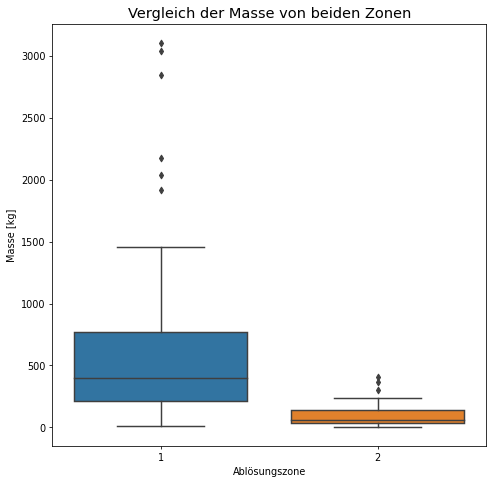

In [34]:
gen_boxplot("Masse [kg]", "Vergleich der Masse von beiden Zonen")

#### 4.3.2 Boxplot Geschwindigkeit

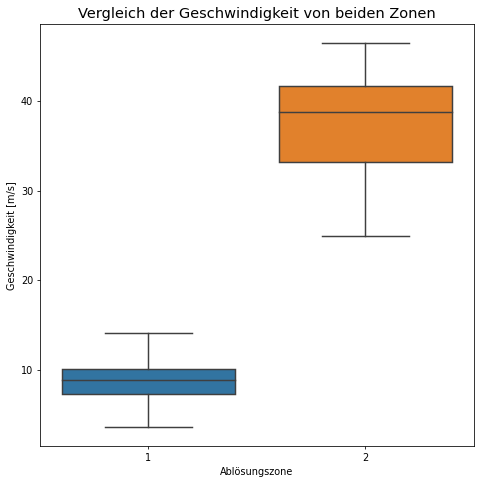

In [35]:
gen_boxplot("Geschwindigkeit [m/s]", "Vergleich der Geschwindigkeit von beiden Zonen")

#### 4.3.3 Streudiagramm
Code Quelle: https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/#1.-Scatter-plot

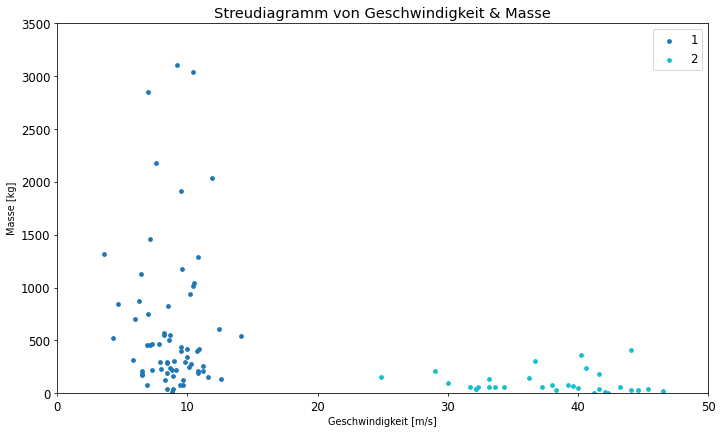

In [36]:
# So vielen Farben erstellen wie es einzigartige Zonen gibt
categories = np.unique(df3['Ablösungszone'])
colors = [plt.cm.tab10(i/float(len(categories)-1)) for i in range(len(categories))]

# Plot zeichnen für die verschiedene Zonen
plt.figure(figsize=(12, 7), dpi= 70, facecolor="w", edgecolor="k")

for i, category in enumerate(categories):
    plt.scatter("Geschwindigkeit [m/s]", "Masse [kg]", 
                data=df3.loc[df3.Ablösungszone == category, :], 
                s=15, c=colors[i], label=str(category))

plt.gca().set(xlim=(0.0, 50), ylim=(0, 3500), xlabel="Geschwindigkeit [m/s]", ylabel="Masse [kg]")

plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Streudiagramm von Geschwindigkeit & Masse", fontsize=15)
plt.legend(fontsize=12)    
plt.show()

#### 4.3.4 Statistik

In [37]:
df1[['Masse [kg]', 'Geschwindigkeit [m/s]']].describe()

,Masse [kg],Geschwindigkeit [m/s]
count,68.000000,68.000000
mean,628.632353,8.788235
std,695.884703,1.989189
min,12.000000,3.600000
25%,214.750000,7.300000
50%,402.500000,8.800000
75%,773.000000,10.125000
max,3104.000000,14.100000


In [38]:
df2[['Masse [kg]', 'Geschwindigkeit [m/s]']].describe()

,Masse [kg],Geschwindigkeit [m/s]
count,32.000000,32.000000
mean,101.062500,37.790625
std,102.785382,5.395778
min,3.000000,24.900000
25%,37.750000,33.200000
50%,58.000000,38.750000
75%,140.000000,41.725000
max,406.000000,46.500000


#### 4.3.5 Bemerkungen
Anhand der erstellten Diagramme konnten wir erkennen, dass Ablösungszone 1 und 2 nicht kombiniert werden sollten, weil die Datensätze stark unterschiedlich sind. Wir nehmen an, dass Zone 2 steiler ist als Zone 1, aufgrund der höheren Geschwindigkeit. Bei Ablösungszone 1 befinden sich deutlich massenhaftere Steine als bei Zone 2.

## 5. Berechnung der Zeitabstände
Wir berechnen jetzt die Zeitabstände in Stunden von den Steinschlägen aus Zone 1 & 2.

Die Zeitabstände wurden durch die Differenz des Datumobjektes berechnet und als neue Attributspalte zu jedem Datensatz hinzugefügt.

Somit haben wir neben der Masse und Geschwindigkeit eine weitere Zufallsvariabel für die Monte Carlo Simulation. 

In [20]:
def zeitabstand_berechnen(zone):
    lst_zeitabstand = []
    for i in range(len(zone)):
        try:
            # Distanz in Stunden berechnen
            distanz_h = int(abs(zone[i] - zone[i+1]).total_seconds() / 3600)
            lst_zeitabstand.append(distanz_h)
        except Exception:
            pass 
        
    return lst_zeitabstand

In [31]:
# Liste erstellen mit Zeiten (Pandas Timestamp Objekt)
zeiten_zone1 = list(i for i in df1["Datum"])
zeiten_zone2 = list(i for i in df2["Datum"])

# Abstand zwischen Steinschlägen berechnen
zeitabstand_zone1 = zeitabstand_berechnen(zeiten_zone1)
zeitabstand_zone2 = zeitabstand_berechnen(zeiten_zone2)

# Dataframe mit Zeitabsständen erstellen
df_zeitabstand_zone1 = pd.DataFrame(zeitabstand_zone1)
df_zeitabstand_zone2 = pd.DataFrame(zeitabstand_zone2)

# Die neue Spaltenname wird von Pandas automatisch als '0' gesetzt. Diese wird nun zu 'Zeitabstand' umbenennt 
df_zeitabstand_zone1 = df_zeitabstand_zone1.rename(columns={0:"Zeitabstand"})
df_zeitabstand_zone2 = df_zeitabstand_zone2.rename(columns={0:"Zeitabstand"})

## 6. Kumulative Funktionsverteilung (CDF)

In diesem Abschnitt entscheiden wir, welche Verteilungen am besten zu unseren Daten passen. Hierzu erstellen wir kumulative Funktionsverteilungen (CDF) mit den verschiedenen Verteilungen wie Normal - oder Exponentialverteilung. Diese Entscheidungen sind sehr wichtig, da diese Verteilungen bei der Simulationen verwendet werden und somit das Endresultat stark beeinflussen können.

Code Quelle: https://medium.com/the-researchers-guide/finding-the-best-distribution-that-fits-your-data-using-pythons-fitter-library-319a5a0972e9

In [32]:
def get_fitted_par(dataframe, x_val, distr):
    vals = dataframe[x_val].values
    fitter_vals = Fitter(vals, distributions=["gamma", "norm", "expon", "lognorm", "cauchy", "exponpow", "powerlaw"])
    fitter_vals.fit()
    
    if distr == "norm":
        return fitter_vals.fitted_param["norm"]
    elif distr == "expon":
        return fitter_vals.fitted_param["expon"]
    elif distr == "lognorm":
        return fitter_vals.fitted_param["lognorm"]
    elif distr == "gamma":
        return fitter_vals.fitted_param["gamma"]
    elif distr == "cauchy":
        return fitter_vals.fitted_param["cauchy"]
    elif distr == "exponpow":
        return fitter_vals.fitted_param["exponpow"]
    elif distr == "powerlaw":
        return fitter_vals.fitted_param["powerlaw"]
    else:
        return "Error"

In [33]:
def gen_cdfplot(dataframe, attribut, xachse):
    verteilungen = ["norm", "expon", "lognorm", "gamma", "cauchy", "exponpow", "powerlaw"]

    # Gleichmässige Punkteveteilung auf der x-Achse
    x = np.linspace(min(dataframe[attribut]),max(dataframe[attribut]), 10000)
    
    plt.figure(figsize=(12, 7), dpi= 80, facecolor='w', edgecolor='k')
    
    loc, scale = get_fitted_par(dataframe, attribut, "norm")
    plt.plot(x,stats.norm.cdf(x, loc, scale))

    loc, scale = get_fitted_par(dataframe, attribut, "expon")
    plt.plot(x,stats.expon.cdf(x, loc, scale))
    
    a, loc, scale = get_fitted_par(dataframe, attribut, "lognorm")
    plt.plot(x,stats.lognorm.cdf(x, a, loc, scale))

    a, loc, scale = get_fitted_par(dataframe, attribut, "gamma")
    plt.plot(x,stats.gamma.cdf(x, a, loc, scale))

    loc, scale = get_fitted_par(dataframe, attribut, "cauchy")
    plt.plot(x,stats.cauchy.cdf(x, loc, scale))

    b, loc, scale = get_fitted_par(dataframe, attribut, "exponpow")
    plt.plot(x,stats.exponpow.cdf(x, b, loc, scale))

    a, loc, scale = get_fitted_par(dataframe, attribut, "powerlaw")
    plt.plot(x,stats.powerlaw.cdf(x, a, loc, scale))
            
    plt.hist(dataframe[attribut], cumulative=True, density=True, bins = 300, alpha = 0.5, color = "skyblue", edgecolor='white')
    plt.ylabel("P(X<=x)")
    plt.xlabel(xachse)
    plt.legend(verteilungen)
    plt.title("Kumulative Funktionsverteilung der {}".format(attribut))

### 6.1 Ablösungszone 1
#### 6.1.1 Masse
Anhand des Diagrammes stellten wir fest, dass die Exponential - und Gammaverteilung gut passen. Bei der Masse ist der obere Teil wichtiger (massenhaftere Steine), da diese Steine das Sicherheitsnetz eher durchbrechen können. Darum haben wir uns für die **Gammaverteilung** entschieden.

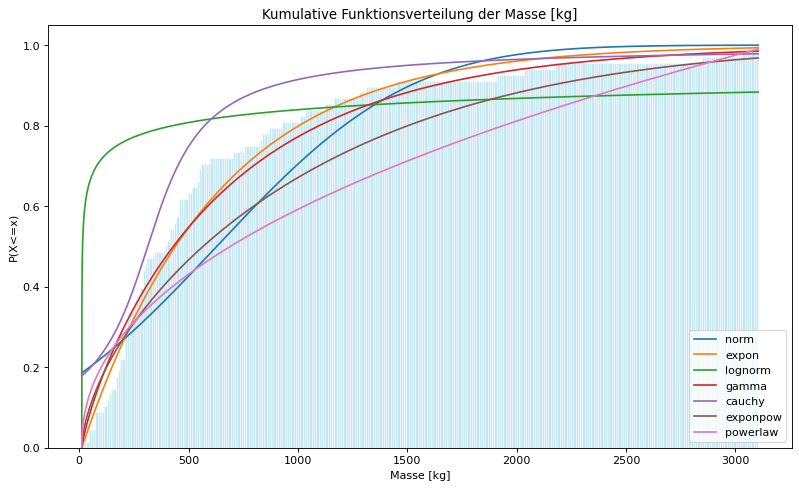

In [34]:
gen_cdfplot(df1, "Masse [kg]", "Masse [kg]")

#### 6.1.2 Geschwindigkeit
Wie bei der Masse, ist bei der Geschwindigkeit der obere Teil wichtiger, da schnellere Steine eine grössere Aufprallenergie haben, die dazu beitragen kann das Netz zu durchbrechen.
Entscheidung: Das Diagramm sieht genau gleich aus wie eine **Normalverteilung**.

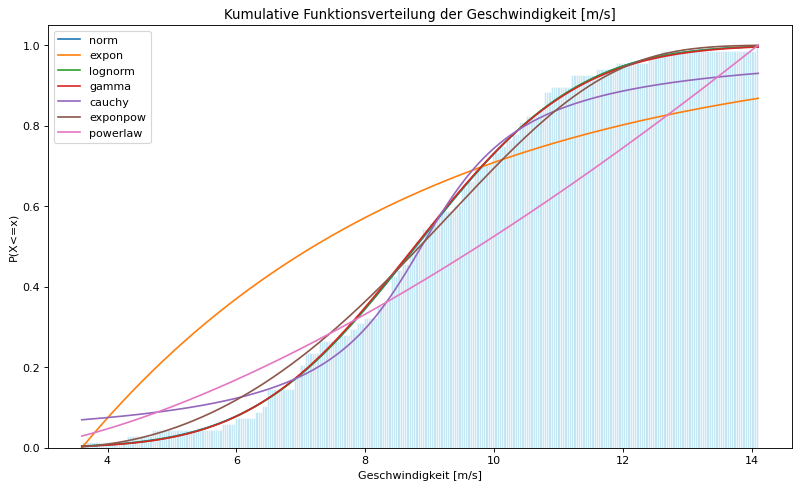

In [35]:
gen_cdfplot(df1, "Geschwindigkeit [m/s]", "Geschwindigkeit [m/s]")

#### 6.1.3 Zeit
Im Gegensatz zur Masse und Geschwindigkeit, ist bei der Zeitabstand der untere Teil wichtiger, weil der Zeitabstand zwischen Steinschlägen natürlich tiefer ist und somit mehr Steine aufprallen können bevor das Netz geleert wird.

Auch wenn über den ganzen Datensatz betrachtet die Exponentialfunktion am besten passt, entscheiden wir uns durch die Überlegungen oben für die **Gammaverteilung**.

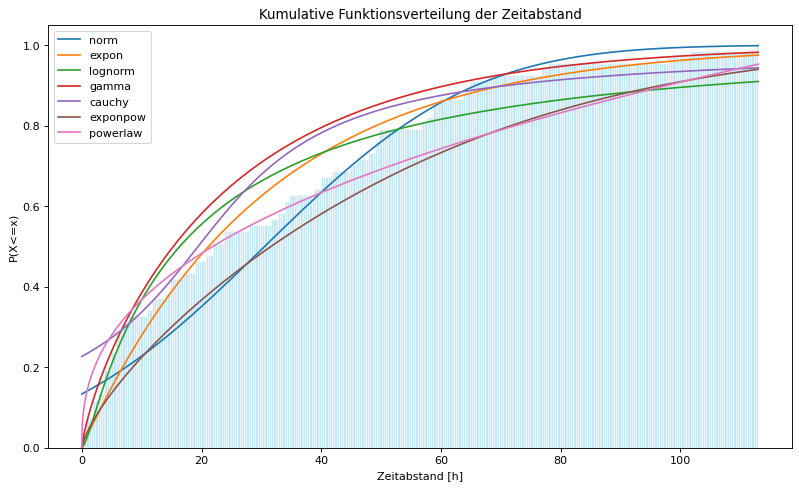

In [36]:
gen_cdfplot(df_zeitabstand_zone1, "Zeitabstand", "Zeitabstand [h]")

### 6.2 Ablösungszone 2
#### 6.2.1 Masse
Analog zu Ablösungszone 1.

**Gammaverteilung**

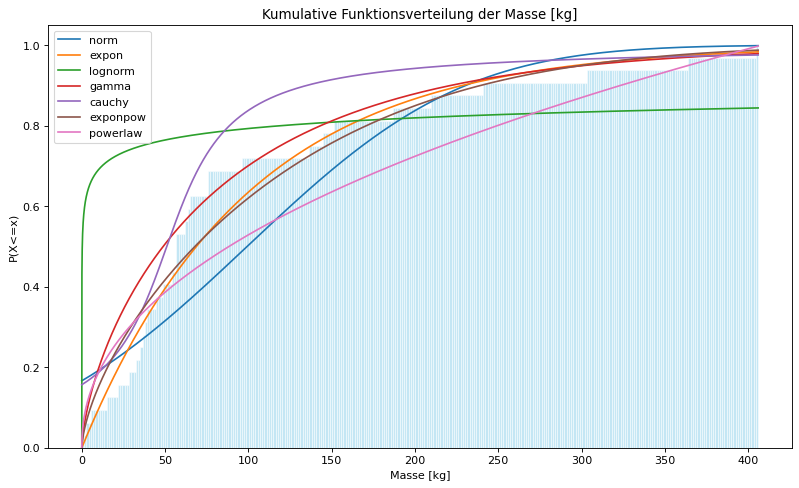

In [37]:
gen_cdfplot(df2, "Masse [kg]", "Masse [kg]")

#### 6.2.2 Geschwindigkeit
Bei der Geschwindigkeit von 35 bis 41 ist die **Powerlaw-Verteilung** am besten und genau dort befinden sich die meisten Geschwindigkeiten der Steinschläge.

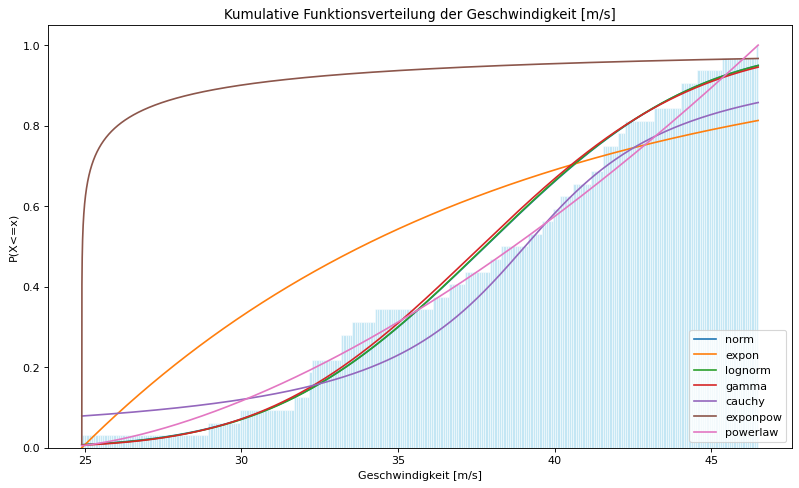

In [38]:
gen_cdfplot(df2, "Geschwindigkeit [m/s]", "Geschwindigkeit [m/s]")

#### 6.2.3 Zeit
**Exponpowverteilung**

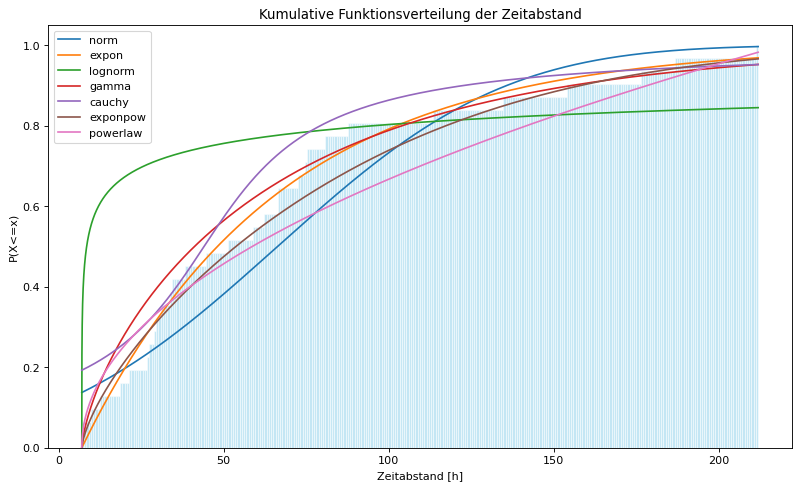

In [39]:
gen_cdfplot(df_zeitabstand_zone2, "Zeitabstand", "Zeitabstand [h]")

## 7. Simulationen

In diesem Abschnitt simulieren wir unsere Daten mit den oben entschiedenen Verteilungen für die Monte Carlo Simulation. 

In [97]:
# Anzahl Daten für die Simulationen
sim_1 = 50_000_000
# Zone 2 wird 3x weniger simuliert, weil es effizienter ist. 
sim_2 = round(sim_1 / 3) 

#np.random.seed(seed=5)

In [98]:
def plot_verteilung(dataframe, x_val):
    sns.set_style("white")
    sns.set_context("paper", font_scale = 1.5)
    sns.displot(data = dataframe, x = x_val, kind = "hist", bins = 150, aspect = 3.0)   

### 7.1 Ablösungszone 1
Code Quelle: https://docs.scipy.org/doc/scipy/reference/stats.html
#### 7.1.1 Masse

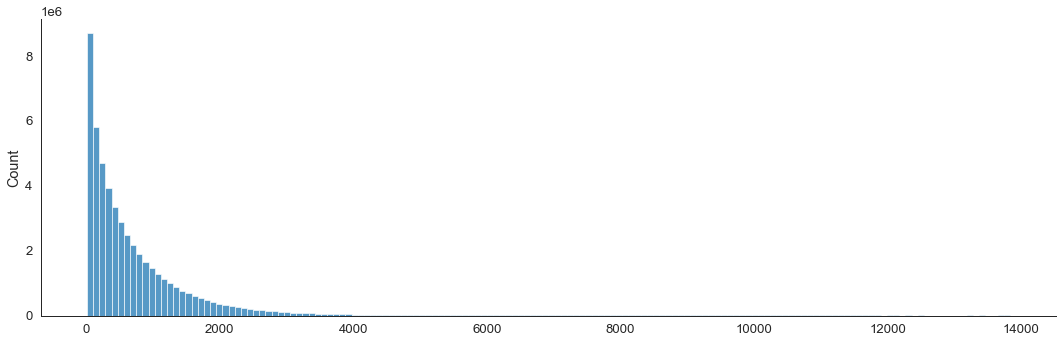

In [99]:
a, loc, scale = get_fitted_par(df1, "Masse [kg]", "gamma")
sim_masse_zone1 = stats.gamma.rvs(a, loc, scale, sim_1) 
df_sim_masse_zone1 = pd.DataFrame(sim_masse_zone1)

plot_verteilung(df_sim_masse_zone1, sim_masse_zone1)

#### 7.1.2 Geschwindigkeit

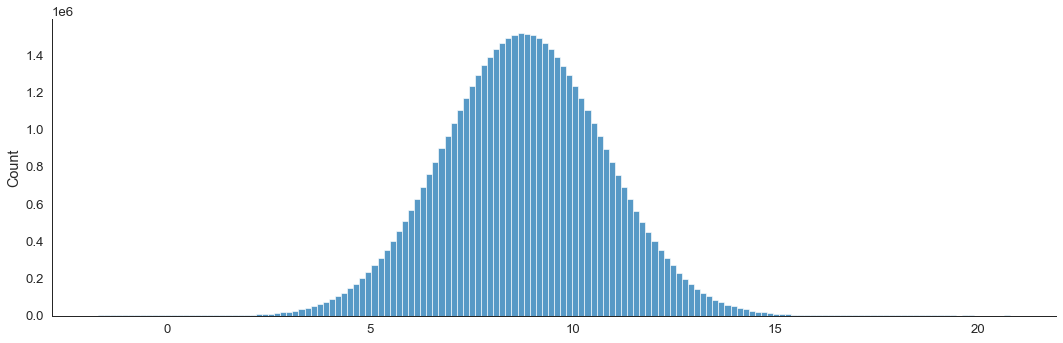

In [100]:
loc, scale = get_fitted_par(df1, "Geschwindigkeit [m/s]", "norm")
sim_geschw_zone1 = stats.norm.rvs(loc, scale, sim_1)
df_sim_geschw_zone1 = pd.DataFrame(sim_geschw_zone1)

plot_verteilung(df_sim_geschw_zone1, sim_geschw_zone1)

#### 7.1.3 Zeitabstand

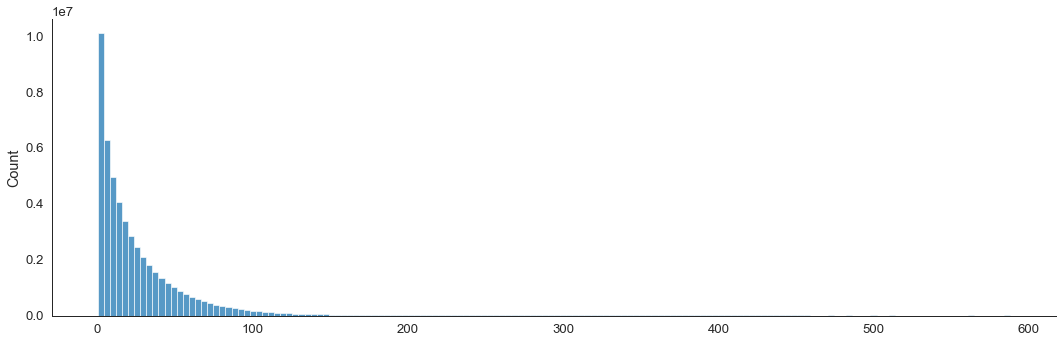

In [101]:
a, loc, scale = get_fitted_par(df_zeitabstand_zone1, "Zeitabstand", "gamma")
sim_zeit_zone1 = stats.gamma.rvs(a, loc, scale, sim_1)
df_sim_zeit_zone1 = pd.DataFrame(sim_zeit_zone1)

plot_verteilung(df_sim_zeit_zone1, sim_zeit_zone1)

### 7.2 Ablösungszone 2
#### 7.2.1 Masse

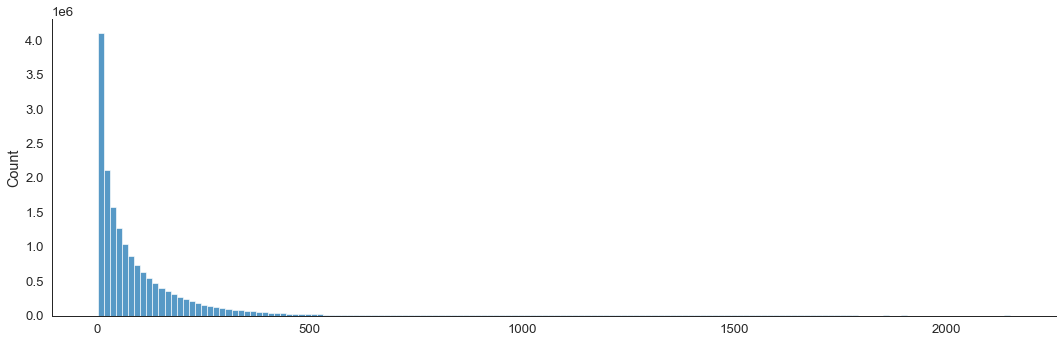

In [102]:
a, loc, scale = get_fitted_par(df2, "Masse [kg]", "gamma")
sim_masse_zone2 = stats.gamma.rvs(a, loc, scale, sim_2) 
df_sim_masse_zone2 = pd.DataFrame(sim_masse_zone2)

plot_verteilung(df_sim_masse_zone2, sim_masse_zone2)

#### 7.2.2 Geschwindigkeit

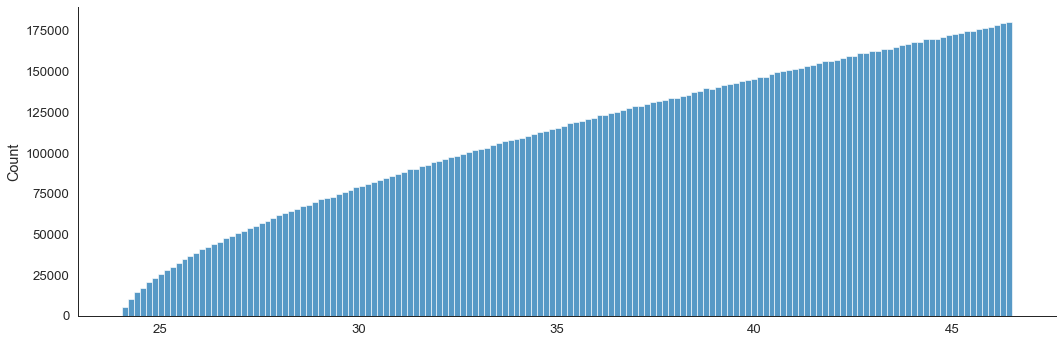

In [103]:
a, loc, scale = get_fitted_par(df2, "Geschwindigkeit [m/s]", "powerlaw")
sim_geschw_zone2 = stats.powerlaw.rvs(a, loc, scale, sim_2)
df_sim_geschw_zone2 = pd.DataFrame(sim_geschw_zone2)

plot_verteilung(df_sim_geschw_zone2, sim_geschw_zone2)

#### 7.2.3 Zeitabstand

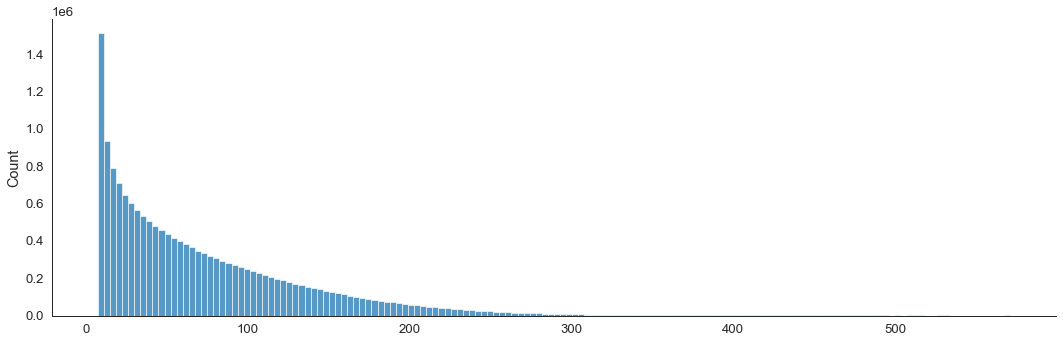

In [104]:
a, loc, scale = get_fitted_par(df_zeitabstand_zone2, "Zeitabstand", "exponpow")
sim_zeit_zone2 = stats.exponpow.rvs(a, loc, scale, sim_2)
df_sim_zeit_zone2 = pd.DataFrame(sim_zeit_zone2)

plot_verteilung(df_sim_zeit_zone2, sim_zeit_zone2)

### 7.3 Dataframe der Simulationen

Hier fügen wir die simulierten Daten in einem Dataframe zusammen. Die Energie wird berechnet und in einer neuen Spalte hinzugefügt und die Zeilenbeschriftungen umbenennt. Dazu berechnen wir den kumulierten Zeitabstand von beiden Zonen und löschen die überschüssigen Daten aus Zone 1.

In [105]:
# simulierte Masse, Geschwindigkeit, Zeit zusammenfügen
df_simulation_zone1 = pd.concat([df_sim_masse_zone1, df_sim_geschw_zone1, df_sim_zeit_zone1], axis=1, join="inner")
df_simulation_zone2 = pd.concat([df_sim_masse_zone2, df_sim_geschw_zone2, df_sim_zeit_zone2], axis=1, join="inner")

# Spalten umbenennen
df_simulation_zone1.columns = ["Masse [kg]", "Geschwindigkeit [m/s]", "Zeitabstand [h]"]
df_simulation_zone2.columns = ["Masse [kg]", "Geschwindigkeit [m/s]", "Zeitabstand [h]"]

# Kumulierter Zeitabstand berechnen
df_simulation_zone1["Kum. Zeitabstand [h]"] = df_simulation_zone1["Zeitabstand [h]"].cumsum().round(1)
df_simulation_zone2["Kum. Zeitabstand [h]"] = df_simulation_zone2["Zeitabstand [h]"].cumsum().round(1)

# Zone 1 auf den kumulierten Zeitabstand von Zone 2 anpassen, weil sonst nur noch Zone 1 simuliert wird.
df_simulation_zone1 = df_simulation_zone1.drop(
    df_simulation_zone1[df_simulation_zone1["Kum. Zeitabstand [h]"] > max(df_simulation_zone2["Kum. Zeitabstand [h]"])].index)

print(sum(df_simulation_zone1["Zeitabstand [h]"]))
print(sum(df_simulation_zone2["Zeitabstand [h]"]))

1190664134.2470698
1190664170.9580667


In [106]:
# Beide Dataframes zusammenfügen
frames = [df_simulation_zone1, df_simulation_zone2]
df_simulation = pd.concat(frames)

# Nach kumulierte Zeit aufsteigend sortieren (Zone 1 und 2 sind jetzt durchmischt und nicht mehr untereinander)
df_simulation = df_simulation.sort_values(by=["Kum. Zeitabstand [h]"])

# Index neu nummerieren
df_simulation = df_simulation.reset_index()

# Alte Index Spalte löschen
df_simulation = df_simulation.drop(['index'], axis=1)

# Differenz der kumulierten Zeit berechnen sowie NA Wert der Delta kumulierte Zeit durch 0 ersetzten
df_simulation["Delta Kum. Zeitabstand [h]"] = df_simulation["Kum. Zeitabstand [h]"].diff().fillna(0)

# Negative Werte im Dataframe loeschen
df_simulation = df_simulation[(df_simulation["Geschwindigkeit [m/s]"] > 0)]

In [113]:
# Anzahl simmulierte Jahre berechnen
# Stunden in 1 Jahr: 8760
verstrichene_zeit = sum(df_simulation["Zeitabstand [h]"]) 
simulierte_jahre = verstrichene_zeit / 8760
print("Anzahl simulierte Jahre: {}".format(simulierte_jahre))

Anzahl simulierte Jahre: 271840.68451211957


## 8. Sicherheitsnetz

#### Angaben aus der Aufgabenstellung:
Sicherheitsnetze sind bis zu einer Aufprallenergie von 1000 kJ sicher.
Netz Falls bereits ein Stein mit über 2000 kg in den Sicherheitsnetzen liegt, beträgt die Aufprallenergie, die von den Sicherheitsnetzen aufgenommen werden kann, nur noch 500 kJ. Steine in den Sicherheitsnetze werden vom Unterhaltsteam entfernt (die Reaktionszeit beträgt 24 Stunden).

Nachfolgend wird die Wahrscheinlichkeit eines Durchbruches aufbrund der Energie und Masse berechnet.

In [108]:
# Berechnung der Energie und Spalte hinzufügen
df_simulation["Energie [kj]"] = (0.5 * df_simulation["Masse [kg]"] * \
                                       df_simulation["Geschwindigkeit [m/s]"] ** 2) / 1000

# Position der Energiespalte ändern
df_simulation = df_simulation[["Masse [kg]", "Geschwindigkeit [m/s]", "Energie [kj]", "Zeitabstand [h]"]]

In [109]:
def durchbruch(masse, energie, kum_masse):
    # Direkter Durchbruch
    if energie >= 1000:
        return True
    
    # Durchbruch mit 2000kg in den Netzen und Aufprallenergie über 500kj
    elif energie >= 500 and kum_masse >= 2000:
        return True
    
    # Kein Durchbruch
    else:
        return False

In [110]:
kum_zeitabstand = 0
kum_masse = 0
anz_durchbrüche = 0

for row in df_simulation.itertuples():   
    masse = row[1]
    geschw = row[2]
    energie = row[3]
    zeitabstand = row[4]
    
    # Anzahl Durchbrüche aufzählen falls das Netz reisst
    if durchbruch(masse, energie, kum_masse):
        anz_durchbrüche += 1
    
    # Zeitabstand ist über 24h 
    # -> Netze werden geleert, d.h. kumulierter Zeitabstand und Masse werden zurückgesetzt
    if zeitabstand >= 24:
        kum_zeitabstand = 0
        kum_masse = 0
        
    # Zeitabstand addiert mit der kumulierten Zeitabstand ist über 24 
    # -> Netze werden geleert, d.h. kumulierter Zeitabstand und Masse werden zurückgesetzt
    if zeitabstand + kum_zeitabstand >= 24:
        kum_zeitabstand = 0
        kum_masse = 0
      
    # Zeitabstände und Masse zusammenzählen
    else:
        kum_zeitabstand += zeitabstand
        kum_masse += masse
        
print("Anzahl Durchbrüche: {}".format(anz_durchbrüche))      

# Durchbrüche pro Jahr
durchbrüche_pro_jahr = anz_durchbrüche / simulierte_jahre
print(durchbrüche_pro_jahr)

Anzahl Durchbrüche: 5121
0.03767651591209128


## 9. Verkehr
#### Angaben aus der Aufgabenstellung:
Das tägliche Verkehrsaufkommen beträgt 1200 Autos. Stau kommt auf der Strecke nicht vor. Die Tempolimite beträgt 60 km/h.

Für die letzte Berechnung mussten wir noch einige Punkte bestimmen bzw recherchieren:

- Autolänge: Die durchschnittliche Länge eines Autos beträgt 4 Meter, aber für die Berechnung haben wir 3 Meter genommen, weil sich Personen meistens vorne befinden. 
- Anzahl Personen im Auto: Die durchschnittliche Anzahl Personen in einem Auto in der Schweiz beträgt 1.56
- Reaktionszeit
- Reaktionsweg
- Wahrscheinlichkeit beim Aufprall zu sterben
- Distanz pro Sekunde

Damit konnten wir 2 Wahrscheinlichkeiten berechnen:
1. Die Wahrscheinlichkeit direkt von einem Stein getroffen zu werden 
2. Die Wahrscheinlichkeit, dass das Auto in den Stein reinfährt

Schlussendlich wurden diese 2 Wahrscheinlichkeiten addiert und mit der Anzahl Durchbrüche pro Jahr und Anzahl Personen im Auto multipliziert.

In [111]:
anz_autos = 1200
anz_autos_stunden = 1200 / 24
anz_autos_minuten = 1200 / 24 / 60
anz_autos_sekunden = 1200 / 24 / 60 / 60

auto_geschw = 60
auto_länge = 3
anz_personen = 1.56

reaktionszeit = 1 
reaktionsweg = auto_geschw / 3.6 * reaktionszeit # 16.6m

distanz_pro_sekunde = (auto_geschw / 3600) * 1000

wk_tod_bei_aufprall = 0.05 

# Wahrscheinlichkeit direkt von einem Stein getroffen zu werden
tödlicher_treffer = auto_länge / distanz_pro_sekunde * anz_autos_sekunden
print("Tödlicher Treffer: {}".format(f"{tödlicher_treffer:.9f}"))

# Wahrscheinlichkeit, dass das Auto in den Stein reinfährt
tödlicher_aufprall = reaktionsweg / distanz_pro_sekunde * anz_autos_sekunden * wk_tod_bei_aufprall 
print("Tödlicher Aufprall: {}".format(f"{tödlicher_aufprall:.9f}"))

# Todeswahrscheinlichkeit pro Jahr ausrechnen
tod_pro_jahr = (tödlicher_treffer + tödlicher_aufprall) * durchbrüche_pro_jahr * anz_personen
print("Todeswahrscheinlichkeit pro Jahr: {}".format(f"{tod_pro_jahr:.9f}"))

Tödlicher Treffer: 0.002500000
Tödlicher Aufprall: 0.000694444
Todeswahrscheinlichkeit pro Jahr: 0.000187755


## 10. Fazit Strassensperrung 

Damit die Strasse offen bleiben kann, muss gezeigt werden, dass die jährliche Wahrscheinlichkeit von Todesfällen infolge Steinschlags kleiner als 10-4 ist.

In [112]:
if tod_pro_jahr >= 0.0001:
    print("Strasse sollte gesperrt werden.")
else:
    print("Die Strasse ist sicher und muss nicht gesperrt werden.")
    
print("Die Todeswahrscheinlichkeit pro Jahr liegt bei {}".format(f"{tod_pro_jahr:.9f}"))

Strasse sollte gesperrt werden.
Die Todeswahrscheinlichkeit pro Jahr liegt bei 0.000187755
